In [32]:
%pip -q install yellowbrick
%pip -q install seaborn
import os
import pandas as pd
import numpy as np
from PIL import Image
import cv2
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import random
import joblib
import seaborn
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [33]:
# Caminho das imagens e classificações
images_path = 'dataset_converted'

# DataFrame inicial
df = pd.DataFrame(columns=['path', 'classification'])
classification_label = []

In [34]:
# Carregar caminhos de imagens e classificações
for f_number, folder in enumerate(os.listdir(images_path)):
    folder_path = os.path.join(images_path, folder)
    classification_label.append(folder)
    for image in os.listdir(folder_path):
        image_path = os.path.join(folder_path, image)
        df.loc[0 if pd.isnull(df.index.max()) else df.index.max() + 1] = [image_path, f_number]

In [35]:
# Verificar se o DataFrame não está vazio
if df.empty:
    raise ValueError("O DataFrame está vazio. Verifique o carregamento das imagens.")

In [36]:
# Função para carregar e pré-processar a imagem
def preprocess_image(image_path):
    # Carregar a imagem e redimensionar para o tamanho esperado pela ResNet50
    image = np.array(Image.open(image_path).convert('RGB').resize((224, 224)))
    # Pré-processar a imagem de acordo com o ResNet50
    image = preprocess_input(image)
    return image

In [37]:
# Aplicar o pré-processamento a todas as imagens
df['image'] = df['path'].apply(preprocess_image)

In [38]:
# Verificar se as imagens foram processadas corretamente
if df['image'].isnull().any():
    raise ValueError("Existem imagens não processadas. Verifique o pré-processamento.")

In [39]:
# Converter a coluna 'image' para uma lista de arrays
X = np.array(df['image'].tolist(), dtype=np.float32)

In [40]:
# Verificar se as classificações estão corretas
if df['classification'].isnull().any():
    raise ValueError("Existem classificações faltantes. Verifique os dados de entrada.")

In [41]:
# Converter classificações para one-hot encoding
y = to_categorical(df['classification'], num_classes=len(classification_label))

In [42]:
# Verificação adicional
print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")
print(f"Data type of X: {X.dtype}")
print(f"Data type of y: {y.dtype}")

Shape of X: (5581, 224, 224, 3)
Shape of y: (5581, 6)
Data type of X: float32
Data type of y: float64


In [43]:
# Separar os dados em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
# Construir o modelo ResNet50
base_model = ResNet50(weights='imagenet', include_top=False)

In [18]:
# Adicionar camadas personalizadas ao modelo
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(len(classification_label), activation='softmax')(x)

In [19]:
# Definir o modelo completo
model = Model(inputs=base_model.input, outputs=predictions)

In [20]:
# Congelar as camadas da base_model
for layer in base_model.layers:
    layer.trainable = False

In [21]:
# Compilar o modelo
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Treinar o modelo resnet50

In [22]:
# Treinar o modelo
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 420s 3s/step - accuracy: 0.7415 - loss: 1.2177 - val_accuracy: 0.7816 - val_loss: 0.6914
Epoch 2/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 384s 3s/step - accuracy: 0.8075 - loss: 0.5644 - val_accuracy: 0.7681 - val_loss: 0.8064
Epoch 3/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 482s 3s/step - accuracy: 0.8369 - loss: 0.4687 - val_accuracy: 0.7932 - val_loss: 0.6295
Epoch 4/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 430s 3s/step - accuracy: 0.8734 - loss: 0.3633 - val_accuracy: 0.7950 - val_loss: 0.7322
Epoch 5/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 400s 3s/step - accuracy: 0.8871 - loss: 0.3003 - val_accuracy: 0.8013 - val_loss: 0.6592
Epoch 6/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 400s 3s/step - accuracy: 0.9214 - loss: 0.2211 - val_accuracy: 0.7950 - val_loss: 0.6490
Epoch 7/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 391s 3s/step - accuracy: 0.9489 - loss: 0.1679 - val_accuracy: 0.8120 - val_loss: 0.7182
Epoch 8/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 410s 3s/step - accuracy: 0.9592 - loss: 0.1333 - val_accu

In [23]:
# Avaliar o modelo no conjunto de teste
accuracy = model.evaluate(X_test, y_test)
print(f"Acurácia no conjunto de teste: {accuracy[1]:.2f}")

35/35 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - accuracy: 0.8042 - loss: 0.7740
Acurácia no conjunto de teste: 0.80


In [28]:
# Salvar o modelo treinado em um arquivo
model.save('modelo_resnet50.h5')
model.save_weights('pesos_resnet50.weights.h5')

In [25]:
# Carregar o modelo treinado a partir do arquivo
modelo_carregado = tf.keras.models.load_model('modelo_resnet50.h5')


In [26]:
# Avaliar o modelo carregado no conjunto de teste
accuracy = modelo_carregado.evaluate(X_test, y_test)
print(f"Acurácia no conjunto de teste após carregar: {accuracy[1]:.2f}")

35/35 ━━━━━━━━━━━━━━━━━━━━ 97s 3s/step - accuracy: 0.8042 - loss: 0.7740
Acurácia no conjunto de teste após carregar: 0.80


# Obtendo métricas e gráficos

In [44]:
modelo = tf.keras.models.load_model('app/inteligencia/resnet50.h5')

In [45]:
predicoes = modelo.predict(X_test)

35/35 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step


In [46]:
label_mapping = {0:'ASC-H', 1:'ASC-US', 2:'HSIL', 3:'LSIL', 4:'Negative for intraepithelial lesion', 5:'SCC'}
labels = [label_mapping[i] for i in range(len(label_mapping))]

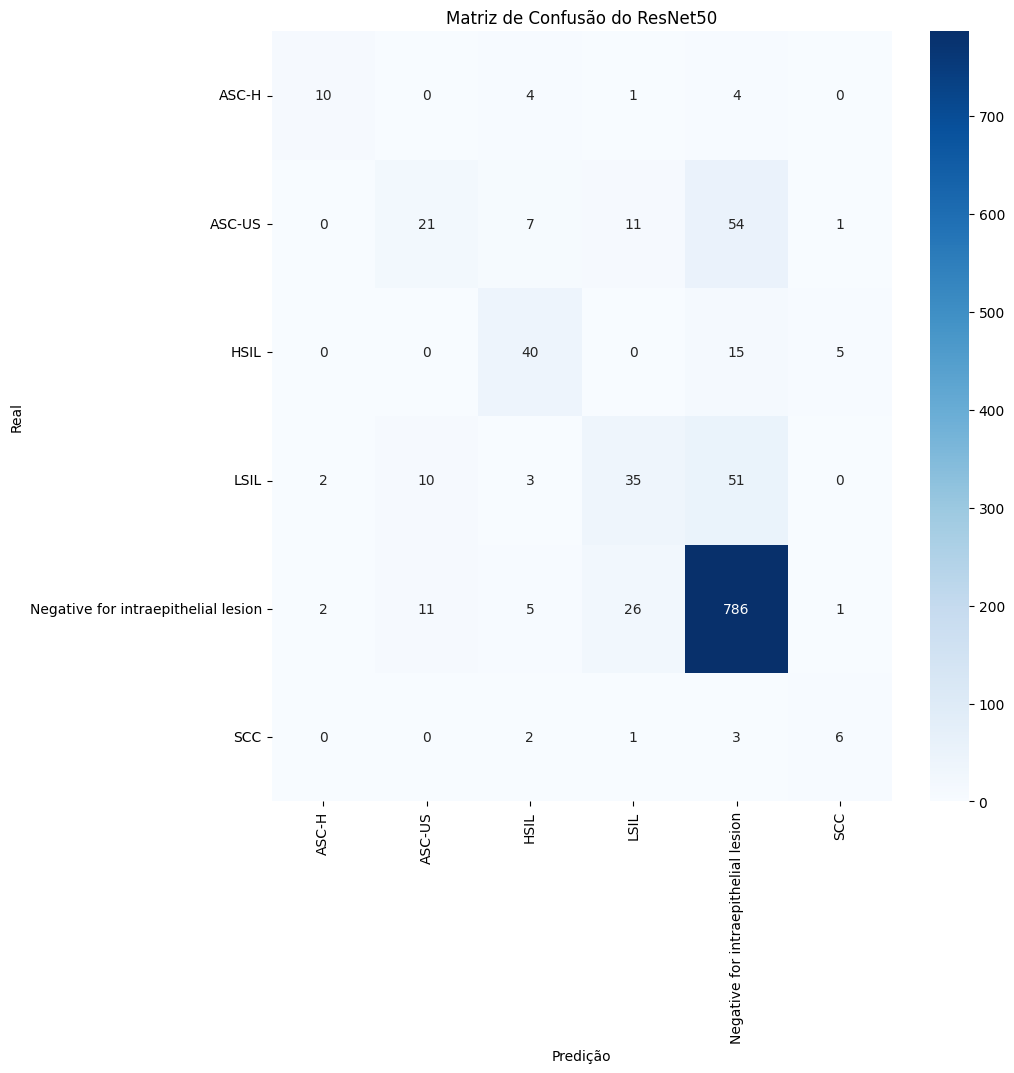

In [48]:
predicoes_ = np.argmax(predicoes, axis=1)
y_test_ = np.argmax(y_test, axis=1)
matriz_confusao = confusion_matrix(y_test_, predicoes_)
plt.figure(figsize=(10, 10))
seaborn.heatmap(matriz_confusao, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predição')
plt.ylabel('Real')
plt.title('Matriz de Confusão do ResNet50')
plt.show()